In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sympy import *
import time
from sympy.parsing.sympy_parser import parse_expr
from kda import plotting, graph_utils, calculations, ode
from kda.plotting import *

In [2]:
k12 = 1
k21 = 1
k23 = 1
k32 = 1
k13 = 1
k31 = 1

#=========== Standard ==============
k3 = np.array([[0, k12, k13],
              [k21, 0, k23],
              [k31, k32, 0]])

k43 = 1
k34 = 1
#=========== Dangling ==============
k3d = np.array([[  0, k12, k13,   0],
                [k21,   0, k23,   0],
                [k31, k32,   0, k34],
                [0  ,   0, k43,   0]])

k41 = 1
k14 = 1
k4 = np.array([[0, k12, 0, k14],
              [k21, 0, k23, 0],
              [0, k32, 0, k34],
              [k41, 0, k43, 0]])

rate_names3 = ["k12", "k21", "k23", "k32", "k13", "k31"]
rate_names3d = ["k12", "k21", "k23", "k32", "k13", "k31", "k43", "k34"]
rate_names4 = ["k12", "k21", "k23", "k32", "k34", "k43", "k14", "k41"]

In [3]:
G3 = nx.MultiDiGraph()
graph_utils.generate_edges(G3, k3)

pos3 = {0 : [0, 1],
        1 : [-np.sqrt(3)/2, -0.5],
        2 : [np.sqrt(3)/2, -0.5]}

G3d = nx.MultiDiGraph()
graph_utils.generate_edges(G3d, k3d)

pos3d = {0 : [0, 0.5],
         1 : [-np.sqrt(3)/2, -0.5],
         2 : [np.sqrt(3)/2, -0.5],
         3 : [(np.sqrt(3)/2) + 1, -0.5]}

G4 = nx.MultiDiGraph()
graph_utils.generate_edges(G4, k4)

pos4 = {0 : [1, 1],
        1 : [-1, 1],
        2 : [-1, -1],
        3 : [1, -1]}

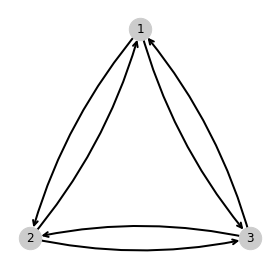

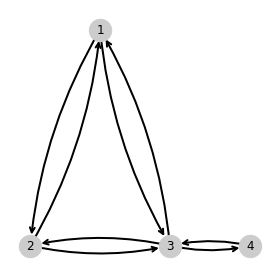

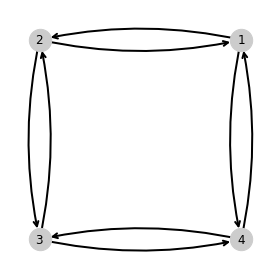

In [4]:
for graph, node_pos in zip([G3, G3d, G4], [pos3, pos3d, pos4]):
    plotting.draw_diagrams(graph, pos=node_pos)

# State Probabilities

In [5]:
probs_3 = calculations.calc_state_probs(G3, key='name', output_strings=True)
probs_3d = calculations.calc_state_probs(G3d, key='name', output_strings=True)
probs_4 = calculations.calc_state_probs(G4, key='name', output_strings=True)

# Plot Probabilities

In [6]:
def gen_rate_dict(K):
    i, j = np.nonzero(K)
    idx_pairs = np.column_stack((i, j))
    rate_dict = {}
    for (i, j) in idx_pairs:
        rate_dict[f"k{i+1}{j+1}"] = K[i, j]
    return rate_dict

In [7]:
def plot_probs(
    K_stat,
    K_dyn,
    leak_arr,
    leak_key,
    rn_stat,
    rn_dyn,
    probs_stat,
    probs_dyn,
    filename="",
):

    rev_arr = 1 / leak_arr
    rev_key = leak_key[0] + leak_key[2] + leak_key[1]

    dict_stat = gen_rate_dict(K_stat)
    # create static (unchanging) state probability functions
    stat_probs = []
    for prob_str in probs_stat:
        f = lambdify(rn_stat, prob_str)
        p = np.ones_like(leak_arr, dtype=np.float64) * f(**dict_stat)
        stat_probs.append(p)

    dict_dyn = gen_rate_dict(K_dyn)
    dict_dyn[leak_key] = leak_arr
    dict_dyn[rev_key] = rev_arr

    # create dynamic (changing) state probability functions
    dyn_probs = []
    for prob_str in probs_dyn:
        f = lambdify(rn_dyn, prob_str)
        p = f(**dict_dyn)
        dyn_probs.append(p)

    x_arr = leak_arr / rev_arr

    fig = plt.figure(figsize=(4, 3), tight_layout=True)
    ax = fig.add_subplot(111)

    stat_colors = ["black", "grey", "brown"]
    dyn_colors = ["blue", "red", "green", "orange", "purple"]
    for i, pi in enumerate(stat_probs):
        color = stat_colors[i]
        label = r"$p_{%s}$" % (i + 1)
        ax.semilogx(x_arr, pi, color=color, ls="--", label=label)

    for i, pi in enumerate(dyn_probs):
        color = dyn_colors[i]
        label = r"$p_{%s}$" % (f"{i + 1}, dang")
        ax.semilogx(x_arr, pi, color=color, ls="--", label=label)

    ax.axvline(x=1, ymin=0, ymax=1, color="black", ls="--")
    ax.set_ylim(-0.05, 1.05)
    ax.set_title("State Probabilities")
    for_str = r"$k_{%s}$" % (leak_key[1:])
    rev_str = r"$k_{%s}$" % (rev_key[1:])
    x_label = f"{for_str}/{rev_str}"
    ax.set_xlabel(x_label)
    ax.legend(bbox_to_anchor=(1, 1))
    if filename:
        plt.savefig(filename, dpi=300)

In [8]:
leak_arr = np.logspace(-2, 2, 101)

kon = 1e10
koff = 1e3
k_conf = 100
cin = 10 ** -6.5
cout = 10 ** -7.5

k12 = kon*cin
k21 = koff
k23 = koff
k32 = kon*cout
k31 = k_conf
k13 = k_conf

# regenerate the rate matrices with new values
k3 = np.array([[0, k12, k13],
              [k21, 0, k23],
              [k31, k32, 0]])

k34 = 100
k43 = 100

k3d = np.array([[  0, k12, k13,   0],
                [k21,   0, k23,   0],
                [k31, k32,   0, k34],
                [0  ,   0, k43,   0]])

k34 = kon * cout
k43 = koff
k14 = k_conf
k41 = k_conf

k4 = np.array([[0, k12, 0, k14],
              [k21, 0, k23, 0],
              [0, k32, 0, k34],
              [k41, 0, k43, 0]])

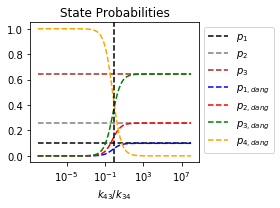

In [22]:
plot_probs(
    K_stat=k3,
    K_dyn=k3d,
    leak_arr=leak_arr,
    leak_key="k43",
    rn_stat=rate_names3,
    rn_dyn=rate_names3d,
    probs_stat=probs_3,
    probs_dyn=probs_3d,
    filename="3_state_vs_dangling_node_probabilities.png",
)

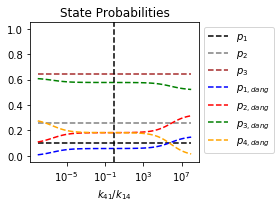

In [21]:
plot_probs(
    K_stat=k3,
    K_dyn=k4,
    leak_arr=leak_arr,
    leak_key="k41",
    rn_stat=rate_names3,
    rn_dyn=rate_names4,
    probs_stat=probs_3,
    probs_dyn=probs_4,
    filename="3_state_vs_4_state_probabilities.png",
)

# Plot Net Cycle Flux

In [11]:
order = [0, 1] # CCW is positive

J_3_state = calculations.calc_net_cycle_flux(G3, [0, 1, 2], order, key='name', output_strings=True)
J_3_state_dangling = calculations.calc_net_cycle_flux(G3d, [0, 1, 2], order, key='name', output_strings=True)
J_4_state = calculations.calc_net_cycle_flux(G4, [0, 1, 2, 3], order, key='name', output_strings=True)

flux3 = lambdify(rate_names3, J_3_state)
flux3d = lambdify(rate_names3d, J_3_state_dangling)
flux4 = lambdify(rate_names4, J_4_state)

Cycle [0, 1, 2] contains all nodes in G, no flux diagrams can be generated. Value of None Returned.
No flux diagrams detected for cycle [0, 1, 2]. Sigma K value is 1.
Cycle [0, 1, 2, 3] contains all nodes in G, no flux diagrams can be generated. Value of None Returned.
No flux diagrams detected for cycle [0, 1, 2, 3]. Sigma K value is 1.


In [12]:
def plot_net_cycle_flux(
    K_stat, K_dyn, leak_arr, leak_key, flux_stat, flux_dyn, filename=""
):

    rev_arr = 1 / leak_arr
    rev_key = leak_key[0] + leak_key[2] + leak_key[1]

    dict_stat = gen_rate_dict(K_stat)
    J_stat = np.ones_like(leak_arr, dtype=np.float64) * flux_stat(**dict_stat)

    dict_dyn = gen_rate_dict(K_dyn)
    dict_dyn[leak_key] = leak_arr
    dict_dyn[rev_key] = rev_arr
    J_dyn = flux_dyn(**dict_dyn)

    fig = plt.figure(figsize=(4, 3), tight_layout=True)
    ax = fig.add_subplot(111)
    ax.semilogx(leak_arr, J_stat, color="blue", ls="--", label=r"$J_{exp}$")
    ax.semilogx(leak_arr, J_dyn, color="red", ls="-", label=r"$J_{dang}$")

    ax.axvline(x=1, ymin=0, ymax=1, color="black", ls="--")
    ax.set_title("Net Cycle Flux")
    for_str = r"$k_{%s}$" % (leak_key[1:])
    rev_str = r"$k_{%s}$" % (rev_key[1:])
    x_label = f"{for_str}/{rev_str}"
    ax.set_xlabel(x_label)
    ax.legend(bbox_to_anchor=(1, 1))
    if filename:
        plt.savefig(filename, dpi=300)

In [13]:
leak_arr = np.logspace(-4, 4, 101)

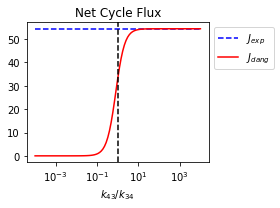

In [23]:
plot_net_cycle_flux(K_stat=k3, K_dyn=k3d, leak_arr=leak_arr, leak_key="k43", flux_stat=flux3, flux_dyn=flux3d, filename="3_state_vs_dangling_node_net_cycle_flux.png")

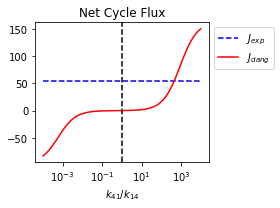

In [24]:
plot_net_cycle_flux(K_stat=k3, K_dyn=k4, leak_arr=leak_arr, leak_key="k41", flux_stat=flux3, flux_dyn=flux4, filename="3_state_vs_4_state_net_cycle_flux.png")

## Flux limits

In [16]:
# NOTE: would need to re-enter ALL symbols to get SymPy to work properly here...
# k43, k34 = symbols("k43, k34")

In [17]:
# J_3_state_dangling

In [18]:
# limit(J_3_state_dangling, k34, 0)

In [19]:
# limit(J_3_state_dangling, k43, 0)